<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/lstm_univariate_timeseries_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pickle
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)



RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]

df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

df=df.groupby("Time").mean()
df.reset_index(inplace=True)

df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01 00:00:00,0.154338,0.144321,15.637208,0.041157,0.01,4.111596
1,2020-01-01 01:00:00,0.156064,0.145520,15.373346,0.041440,0.01,4.160439
2,2020-01-01 02:00:00,0.155957,0.146585,15.122024,0.041997,0.01,4.212914
3,2020-01-01 03:00:00,0.155334,0.143598,14.902892,0.043065,0.01,4.331691
4,2020-01-01 04:00:00,0.157375,0.144605,14.703281,0.047041,0.01,4.693571


In [5]:
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H")

# Train Test 

In [6]:
data1=df.copy()

In [7]:
ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]
ariza_index = []
for i in ariza_tarihleri:
  ariza_index.append(df[df["Time"]==i].index[0])

In [8]:
drop_index_list=[]
for a in ariza_index:

  for i in range(0,24*7):
    drop_index_list.append(a+i)
  for i in range(0,24*2):
    drop_index_list.append(a-i)

In [9]:
df.drop(index=drop_index_list,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

In [10]:
data =df.copy()

In [11]:
ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]

In [12]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
def lstm_anomaly(df,col,time_step,threshold):
    print(f"{col}"+50*"*")
    df  = data.copy()
    df.set_index("Time",inplace=True)
    df1=df[[col]]
    df2=data1.copy()
    print(df2)
    df2.set_index("Time",inplace= True)
    print(df2)
    df3=df2[[col]]
    train_size=df2.shape[0]
    train, test = df1.iloc[24*30:train_size], df3[df3.index>"2020-01-01 15:00:00"]
    print(train.shape, test.shape)
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    

    scaler = StandardScaler()
    scaler = scaler.fit(train[[col]])

    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
    pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl",scaler)    
           
    TIME_STEPS = time_step
    
    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train[[col]], train[col], TIME_STEPS)
    X_test, y_test = create_dataset(test[[col]], test[col], TIME_STEPS)

    print(X_train.shape)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(
            units=64, 
            input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
        
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,verbose=1
    )
   
    model.save(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_anomaly_model.h5")
    X_train_pred = model.predict(X_train)

    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    
    X_test_pred = model.predict(X_test)

    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    
    THRESHOLD = threshold

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[col] = test[TIME_STEPS:][col]
    
    anomalies = test_score_df[test_score_df.anomaly == True]
    
    train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
    train_score_df['loss'] = train_mae_loss
    train_score_df['threshold'] = THRESHOLD
    train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
    train_score_df[col] = train[TIME_STEPS:][col]
    
    anomalies_train = train_score_df[train_score_df.anomaly == True]
    
    return anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler

In [15]:
def loss_and_threshold_value_plot():
    plt.plot(test_score_df.index, test_score_df.loss, label='loss_'+col)
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold_'+col)
    plt.xticks(rotation=25)
    plt.legend();

In [16]:
def train_mae_loss():
    sns.distplot(train_mae_loss, bins=50, kde=True);


In [17]:
def anomaly_plot(test,anomalies,col):
    ariza_tarihleri_plot= []
    for i in [str(a) for a in data1["Time"]]:
          if i not in [str(b) for b in ariza_tarihleri]:
            ariza_tarihleri_plot.append(data1[col].min())
          else:
            ariza_tarihleri_plot.append(data1[col].max())
    ariza=pd.DataFrame(ariza_tarihleri_plot)
    ariza.index=data1["Time"]
    ariza.columns=["ariza tarihleri"]

    print(anomalies.head(10))
    plt.figure(figsize=(24, 12), dpi=80)
    plt.plot(
          test[TIME_STEPS:].index, 
          scaler.inverse_transform(test[TIME_STEPS:][col]), 
          label=col
        );

    sns.scatterplot(
          anomalies.index,
          scaler.inverse_transform(anomalies[col]),
          color=sns.color_palette()[3],
          s=52,
          label='anomaly_'+col
        )
    plt.plot(ariza["ariza tarihleri"],label="ariza tarihleri")
    plt.xticks(rotation=25)
    plt.legend();
    plt.show()

In [18]:
def loss_plot():
    plt.plot(history.history['loss'], label='train loss_'+col)
    plt.plot(history.history['val_loss'], label='test loss_'+col)
    plt.legend();


In [19]:
total_anomalies = pd.DataFrame()


# vibx 

In [20]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibx", time_step=24, threshold=1.4)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibx**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
8282 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
8283 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
8284 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
8285 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
8286 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6384, 24, 1)
Epoch 1/50
180/180 [==============================] - 10s 10ms/step - loss: 0.2819 - val_loss: 0.1608
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2312 - val_loss: 0.1445
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2203 - val_loss: 0.1421
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2088 - val_loss: 0.1284
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2032 - val_loss: 0.1287
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1982 - val_loss: 0.1254
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1965 - val_loss: 0.1281
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1940 - val_loss: 0.1219
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1944 - val_loss: 0.1270
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1916 - 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


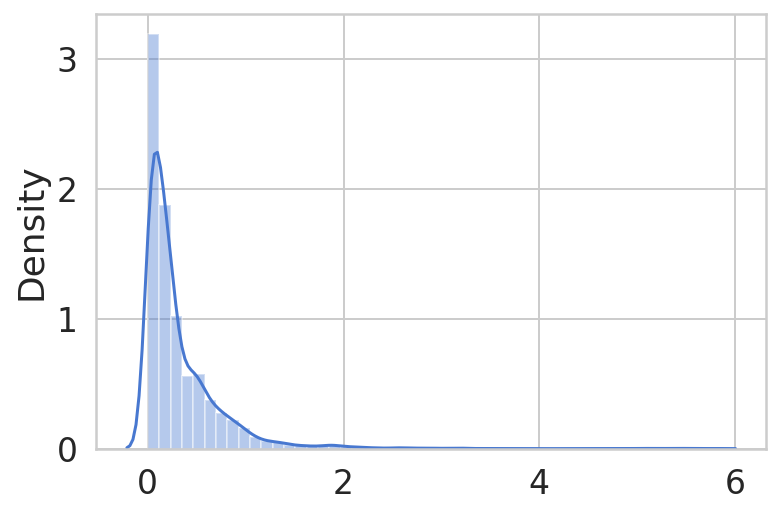

In [21]:
sns.distplot(train_mae_loss, bins=50, kde=True)

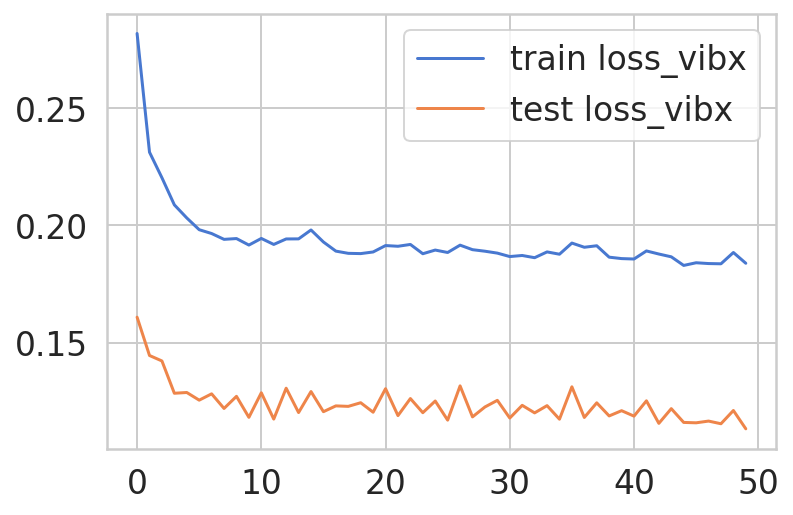

In [22]:
loss_plot()

                         loss  threshold  anomaly      vibx
Time                                                       
2020-02-02 22:00:00  1.697548        1.4     True  0.396855
2020-02-16 22:00:00  1.541870        1.4     True  0.377517
2020-03-23 06:00:00  1.871155        1.4     True  0.559276
2020-03-25 06:00:00  1.578691        1.4     True  0.666006
2020-03-26 06:00:00  1.453327        1.4     True  0.678314
2020-03-27 07:00:00  1.448089        1.4     True  0.675224
2020-04-06 06:00:00  1.608329        1.4     True  0.772842
2020-04-06 07:00:00  1.455715        1.4     True  0.810404
2020-04-06 08:00:00  1.435717        1.4     True  0.834848
2020-04-06 09:00:00  1.424136        1.4     True  0.826631


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


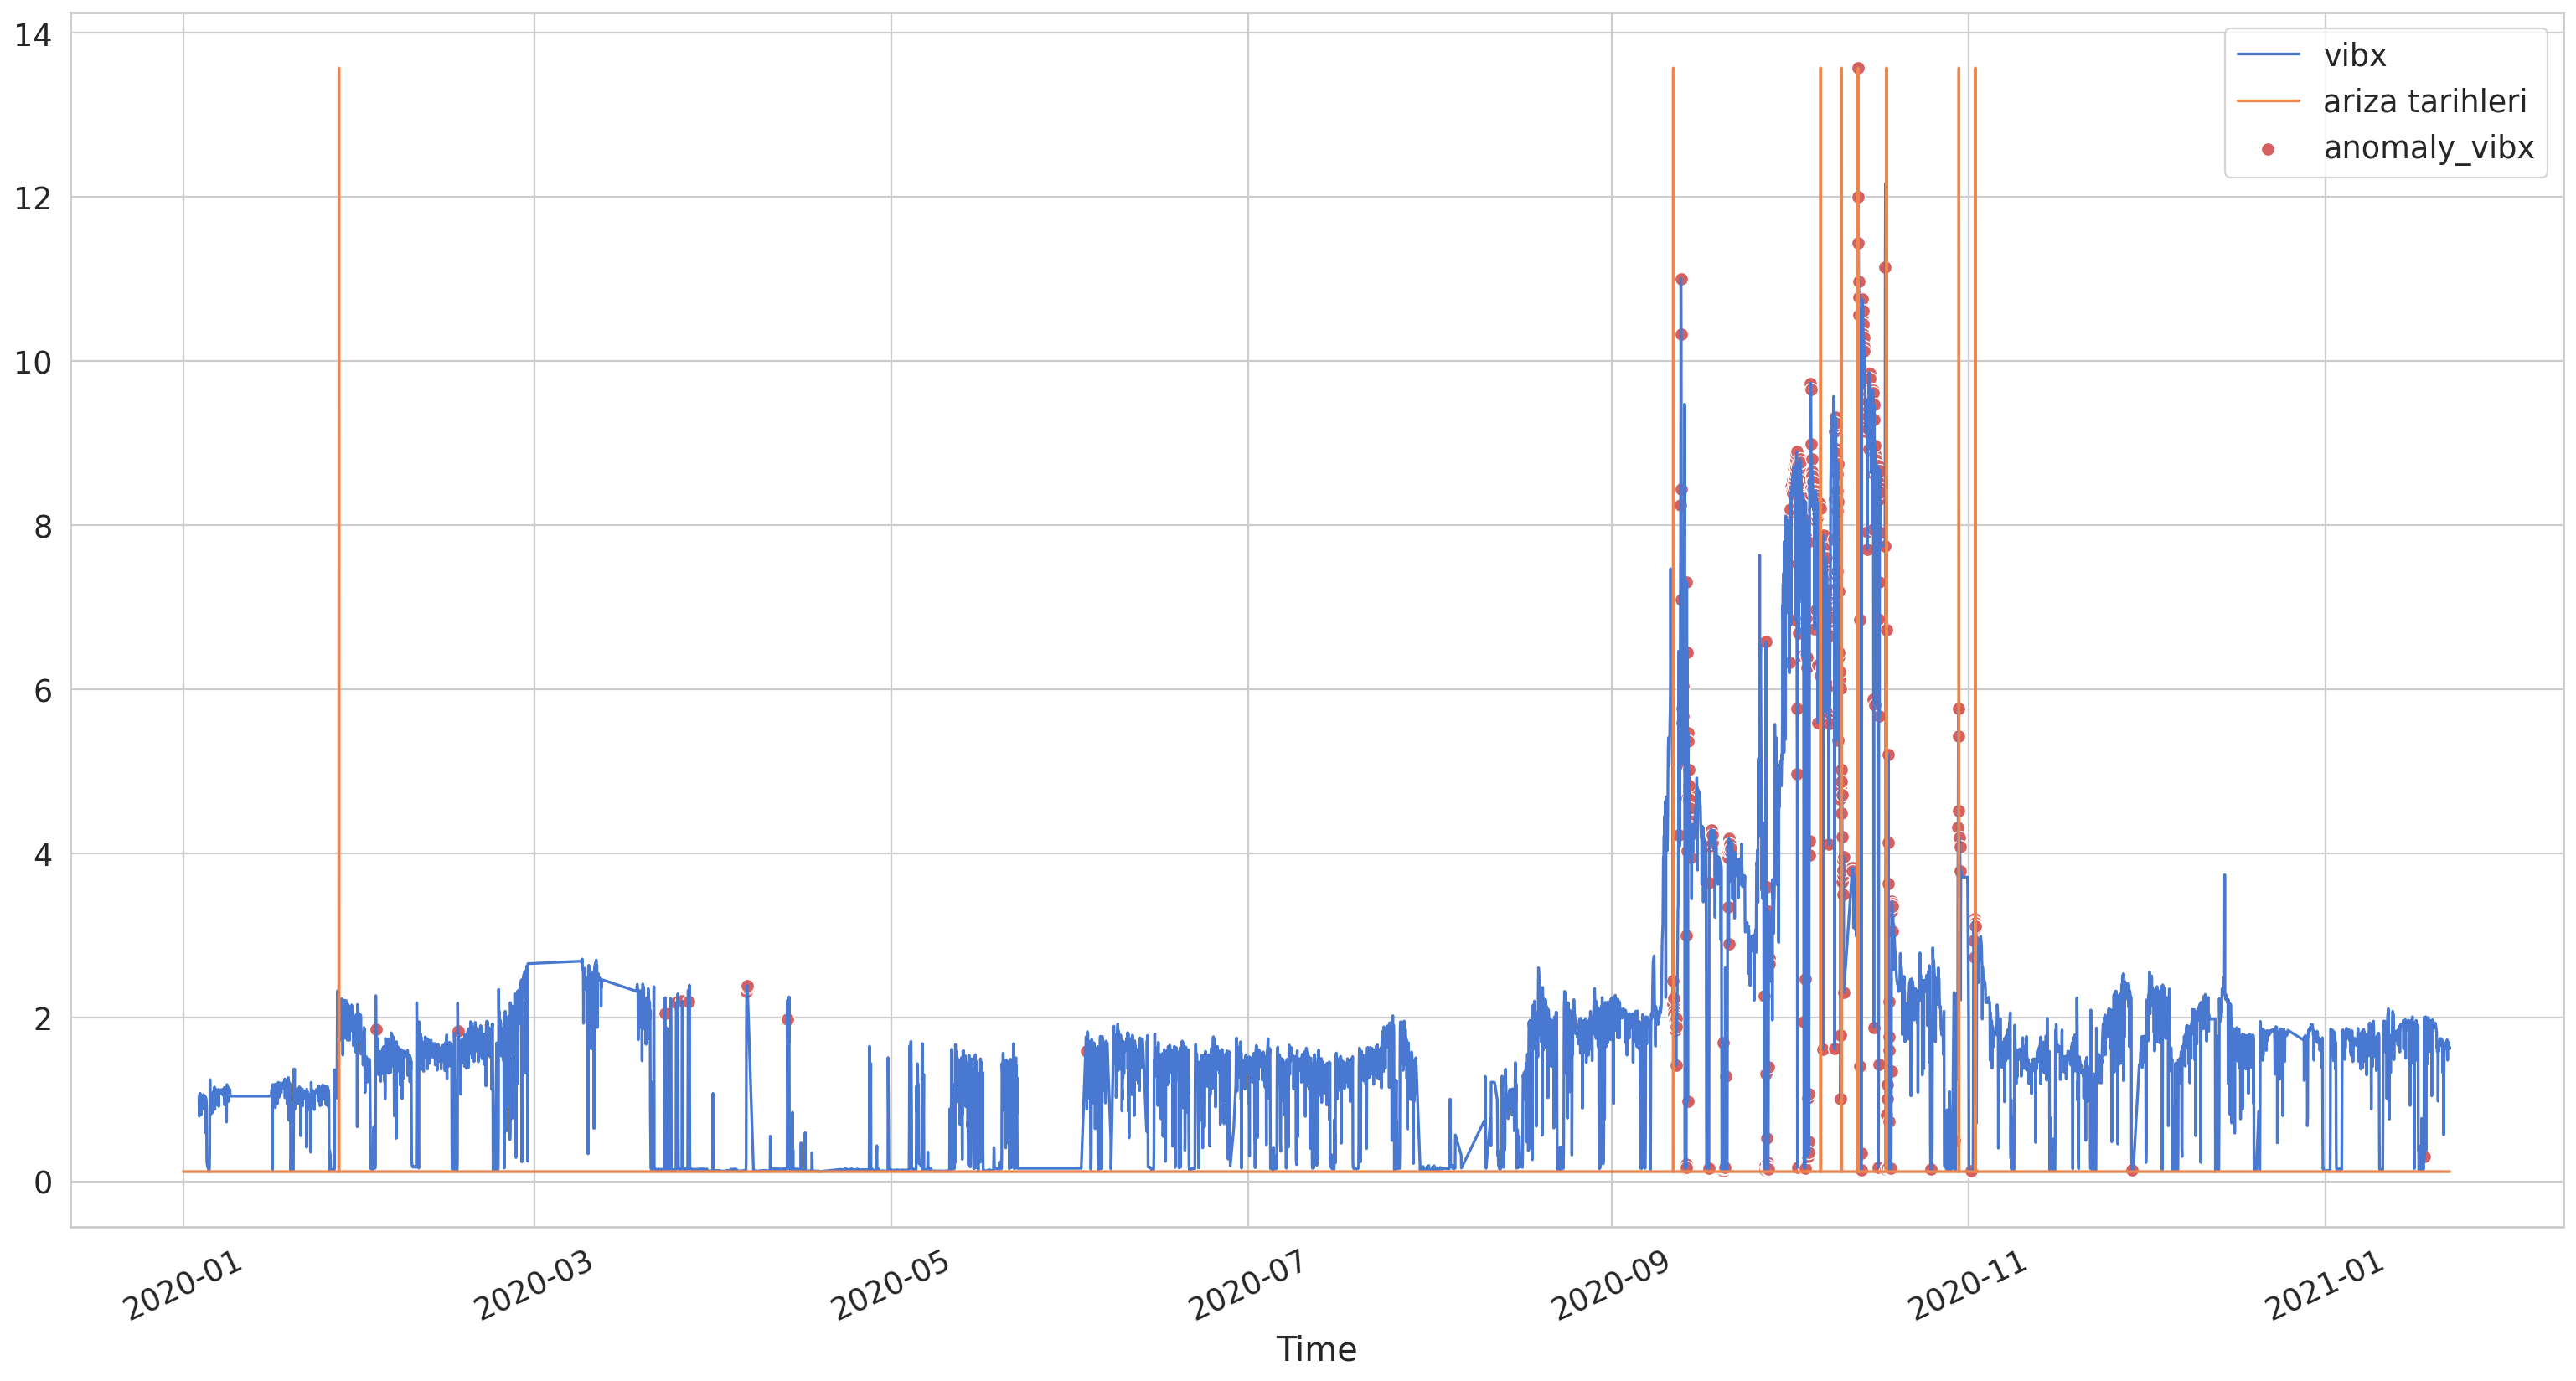

In [23]:
anomaly_plot(test,anomalies=anomalies,col="vibx")

# vibz

In [24]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibz",time_step=24,threshold=1.7)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibz**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
8282 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
8283 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
8284 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
8285 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
8286 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6384, 24, 1)
Epoch 1/50
180/180 [==============================] - 4s 9ms/step - loss: 0.2646 - val_loss: 0.1700
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2050 - val_loss: 0.1453
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1992 - val_loss: 0.1480
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1871 - val_loss: 0.1370
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1800 - val_loss: 0.1327
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1836 - val_loss: 0.1394
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1753 - val_loss: 0.1299
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1735 - val_loss: 0.1326
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1764 - val_loss: 0.1343
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1720 - va

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


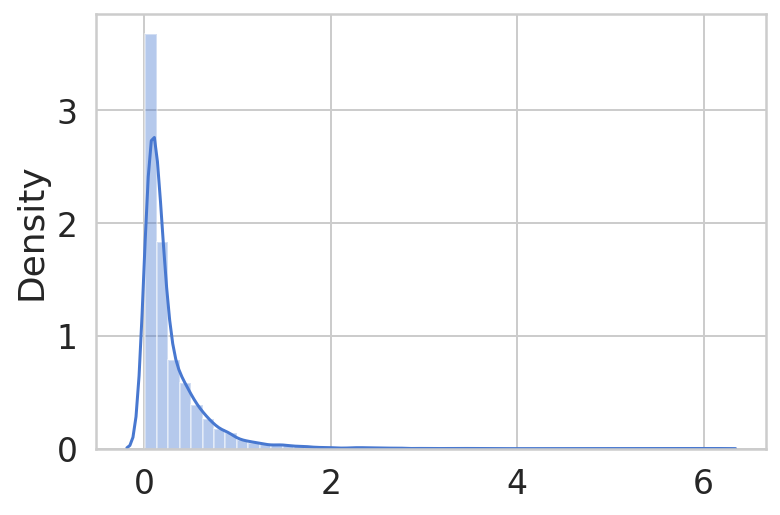

In [25]:
sns.distplot(train_mae_loss, bins=50, kde=True)

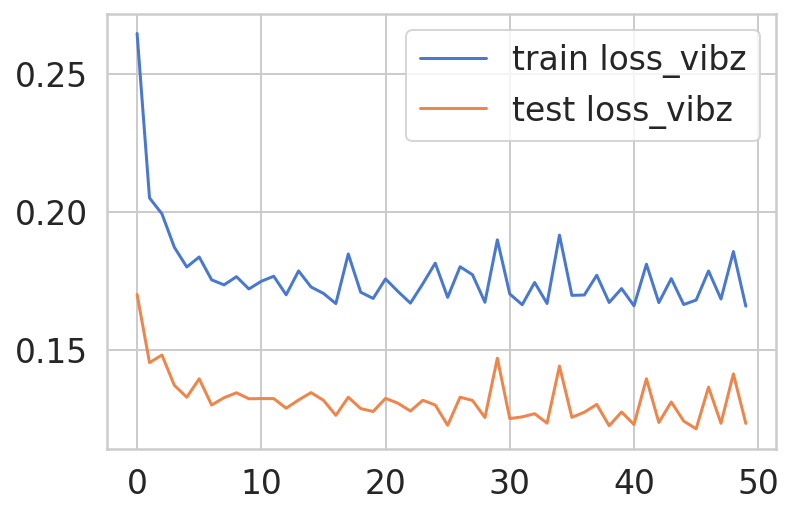

In [26]:
loss_plot()

                         loss  threshold  anomaly      vibz
Time                                                       
2020-01-27 09:00:00  1.957414        1.7     True  2.114998
2020-01-27 10:00:00  2.072212        1.7     True  2.306997
2020-01-27 11:00:00  2.058532        1.7     True -0.213910
2020-09-11 13:00:00  2.238915        1.7     True  0.144726
2020-09-11 14:00:00  2.610730        1.7     True  0.441012
2020-09-11 15:00:00  2.345394        1.7     True  0.451570
2020-09-11 16:00:00  2.283230        1.7     True  0.412575
2020-09-11 17:00:00  2.214238        1.7     True  0.432817
2020-09-11 18:00:00  2.103363        1.7     True  0.321597
2020-09-11 19:00:00  2.064726        1.7     True  0.327362


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


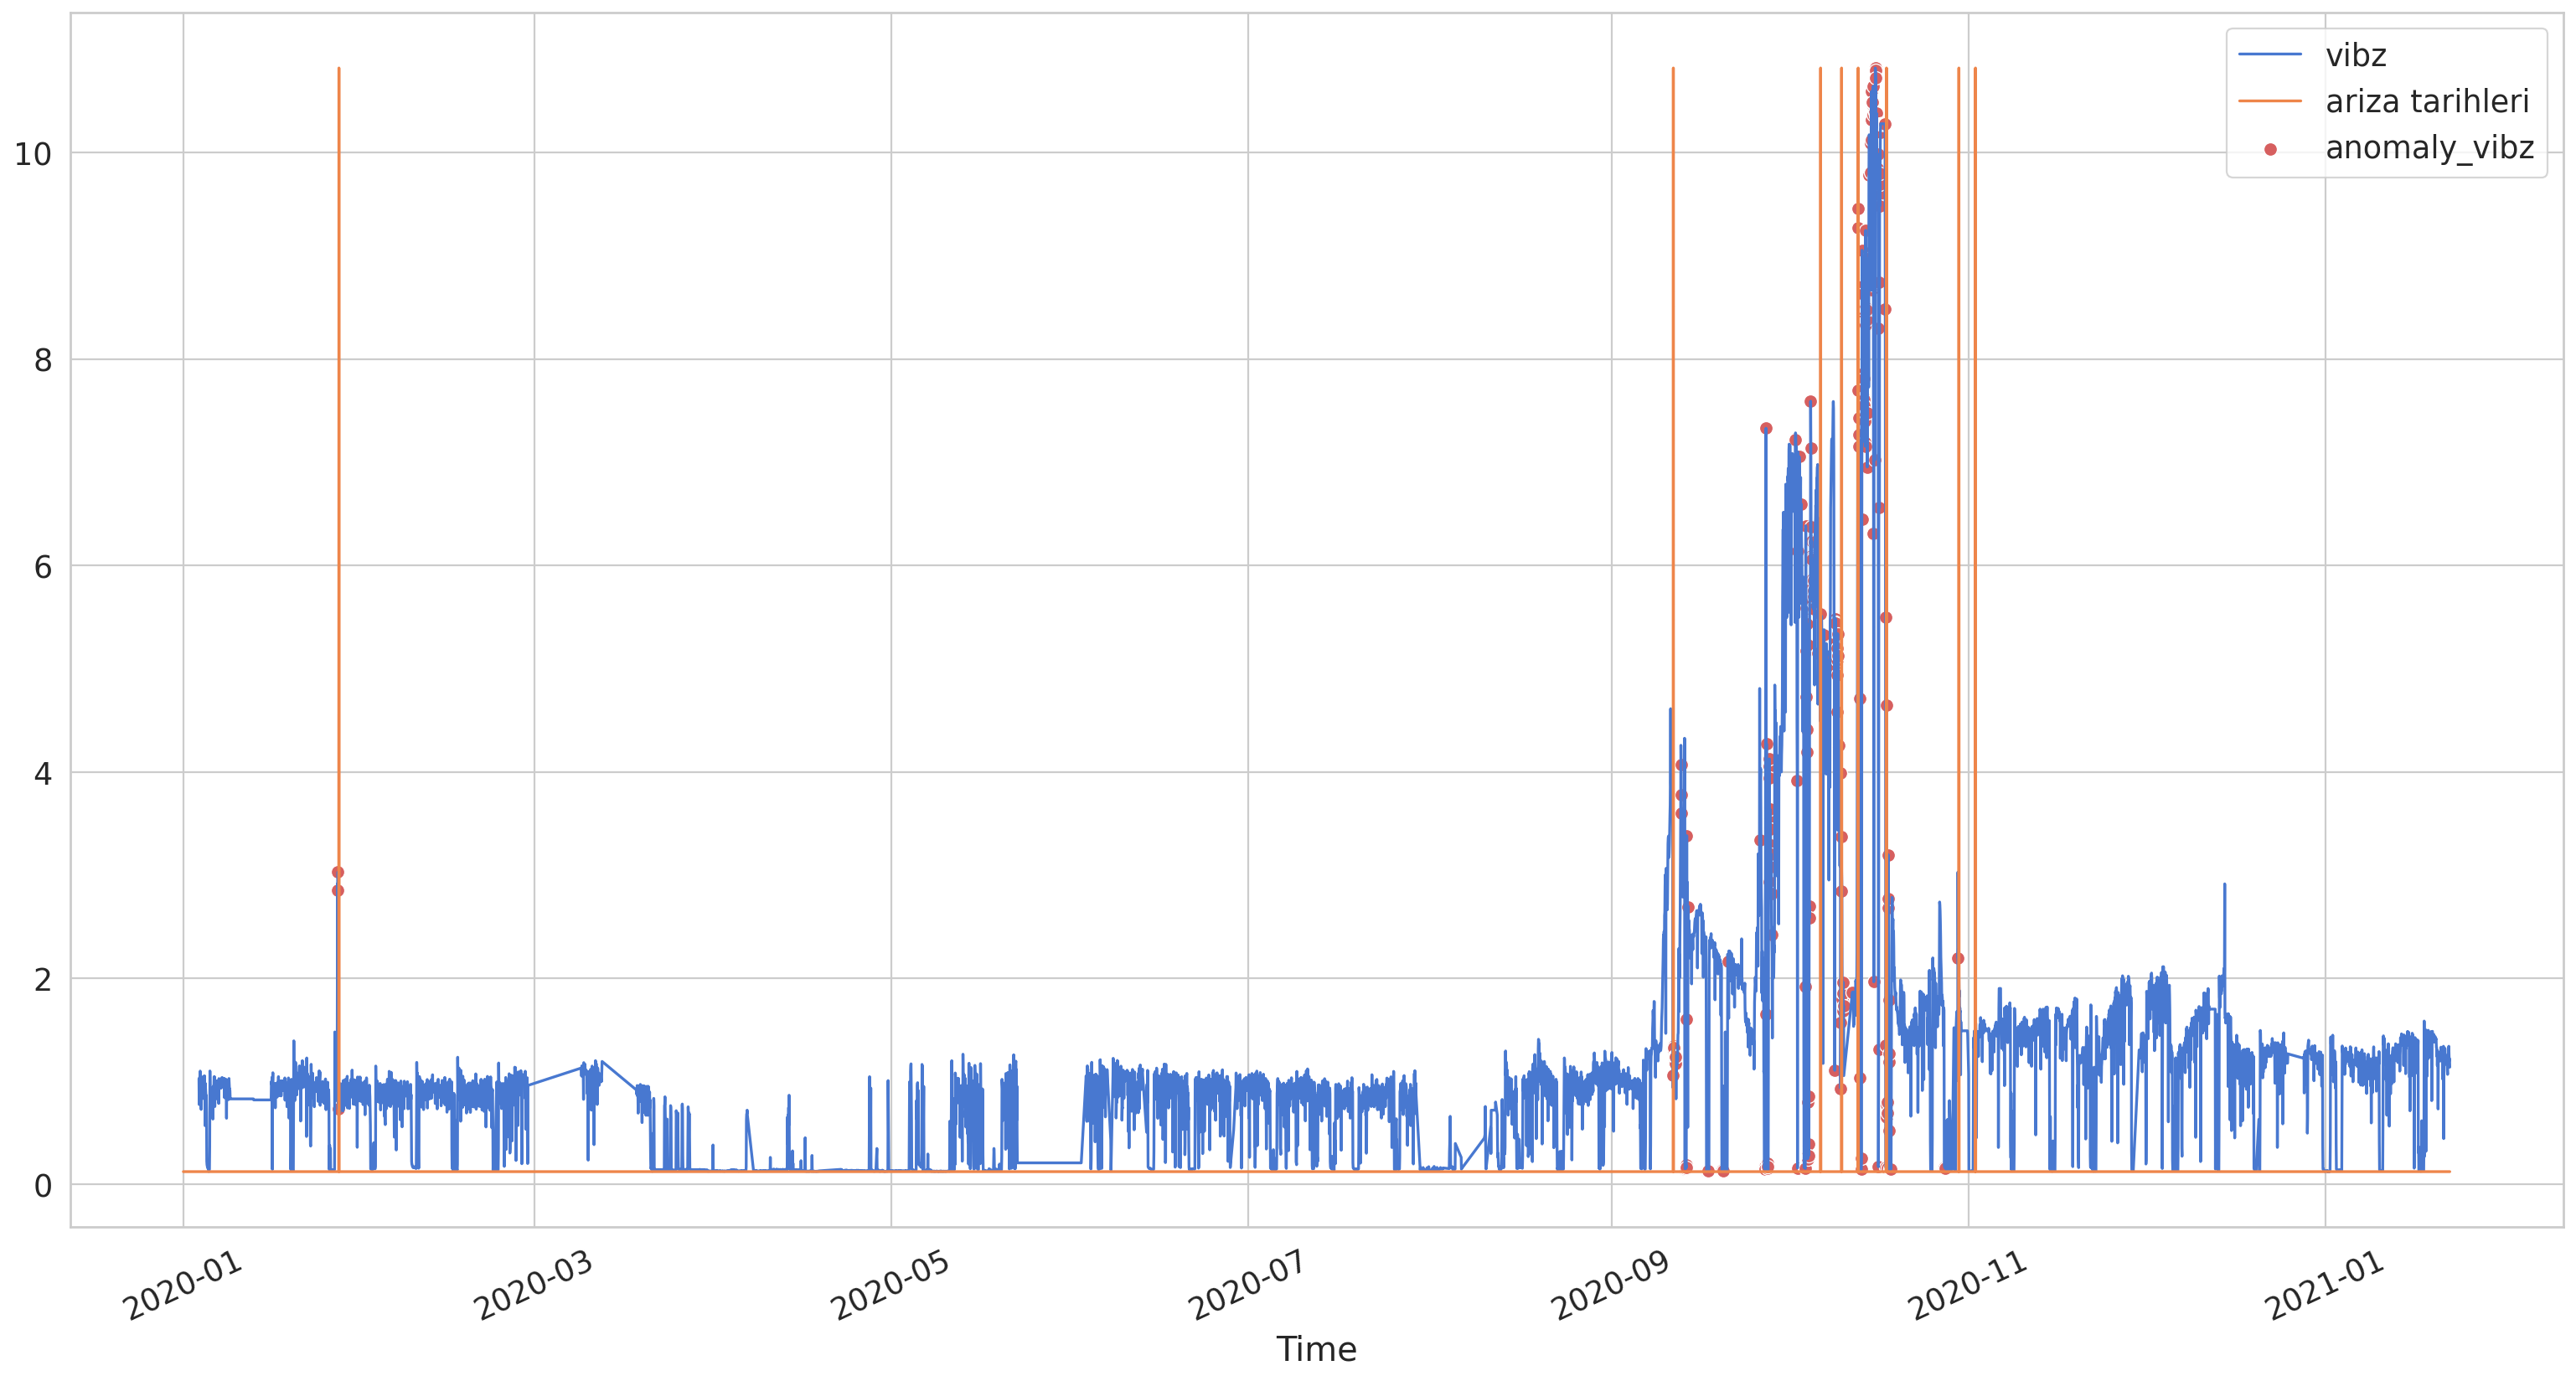

In [27]:
anomaly_plot(test,anomalies=anomalies,col="vibz")

# temp

In [28]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="temp",time_step=24,threshold=1.2)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

temp**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
8282 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
8283 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
8284 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
8285 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
8286 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6384, 24, 1)
Epoch 1/50
180/180 [==============================] - 4s 9ms/step - loss: 0.2449 - val_loss: 0.1815
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1845 - val_loss: 0.1420
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1611 - val_loss: 0.1244
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1508 - val_loss: 0.1100
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1439 - val_loss: 0.1022
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1403 - val_loss: 0.1011
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1355 - val_loss: 0.0980
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1340 - val_loss: 0.1016
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1326 - val_loss: 0.0996
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1322 - va

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


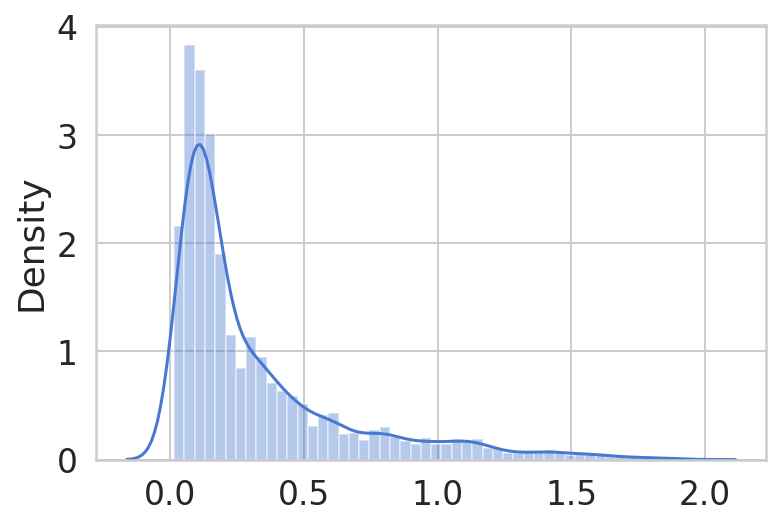

In [29]:
sns.distplot(train_mae_loss, bins=50, kde=True)

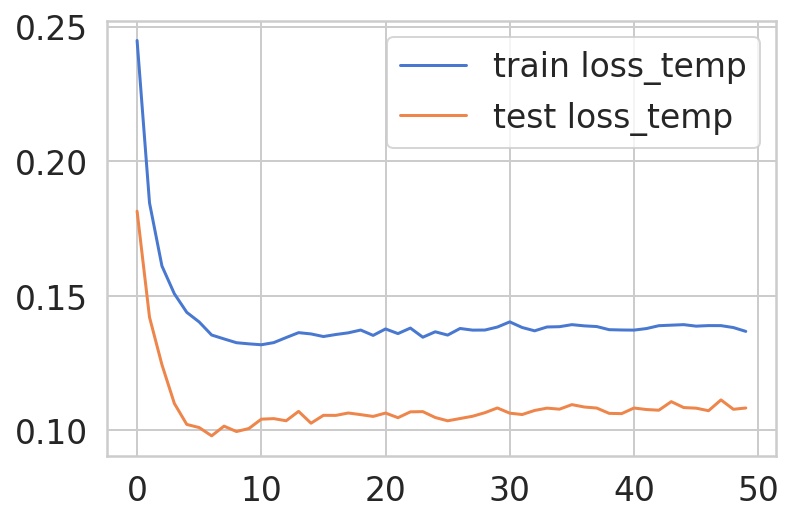

In [30]:
loss_plot()

                         loss  threshold  anomaly      temp
Time                                                       
2020-01-27 02:00:00  1.242778        1.2     True -0.581672
2020-02-10 05:00:00  1.613348        1.2     True -0.809970
2020-03-23 10:00:00  1.314685        1.2     True -0.458401
2020-03-23 12:00:00  1.458669        1.2     True -0.293700
2020-03-25 09:00:00  1.451024        1.2     True -0.715674
2020-03-25 14:00:00  1.410495        1.2     True -0.213606
2020-03-27 10:00:00  1.377048        1.2     True -0.485404
2020-03-27 13:00:00  1.425593        1.2     True  0.016298
2020-03-27 14:00:00  1.387057        1.2     True -0.448451
2020-04-06 07:00:00  1.221849        1.2     True -0.674051


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


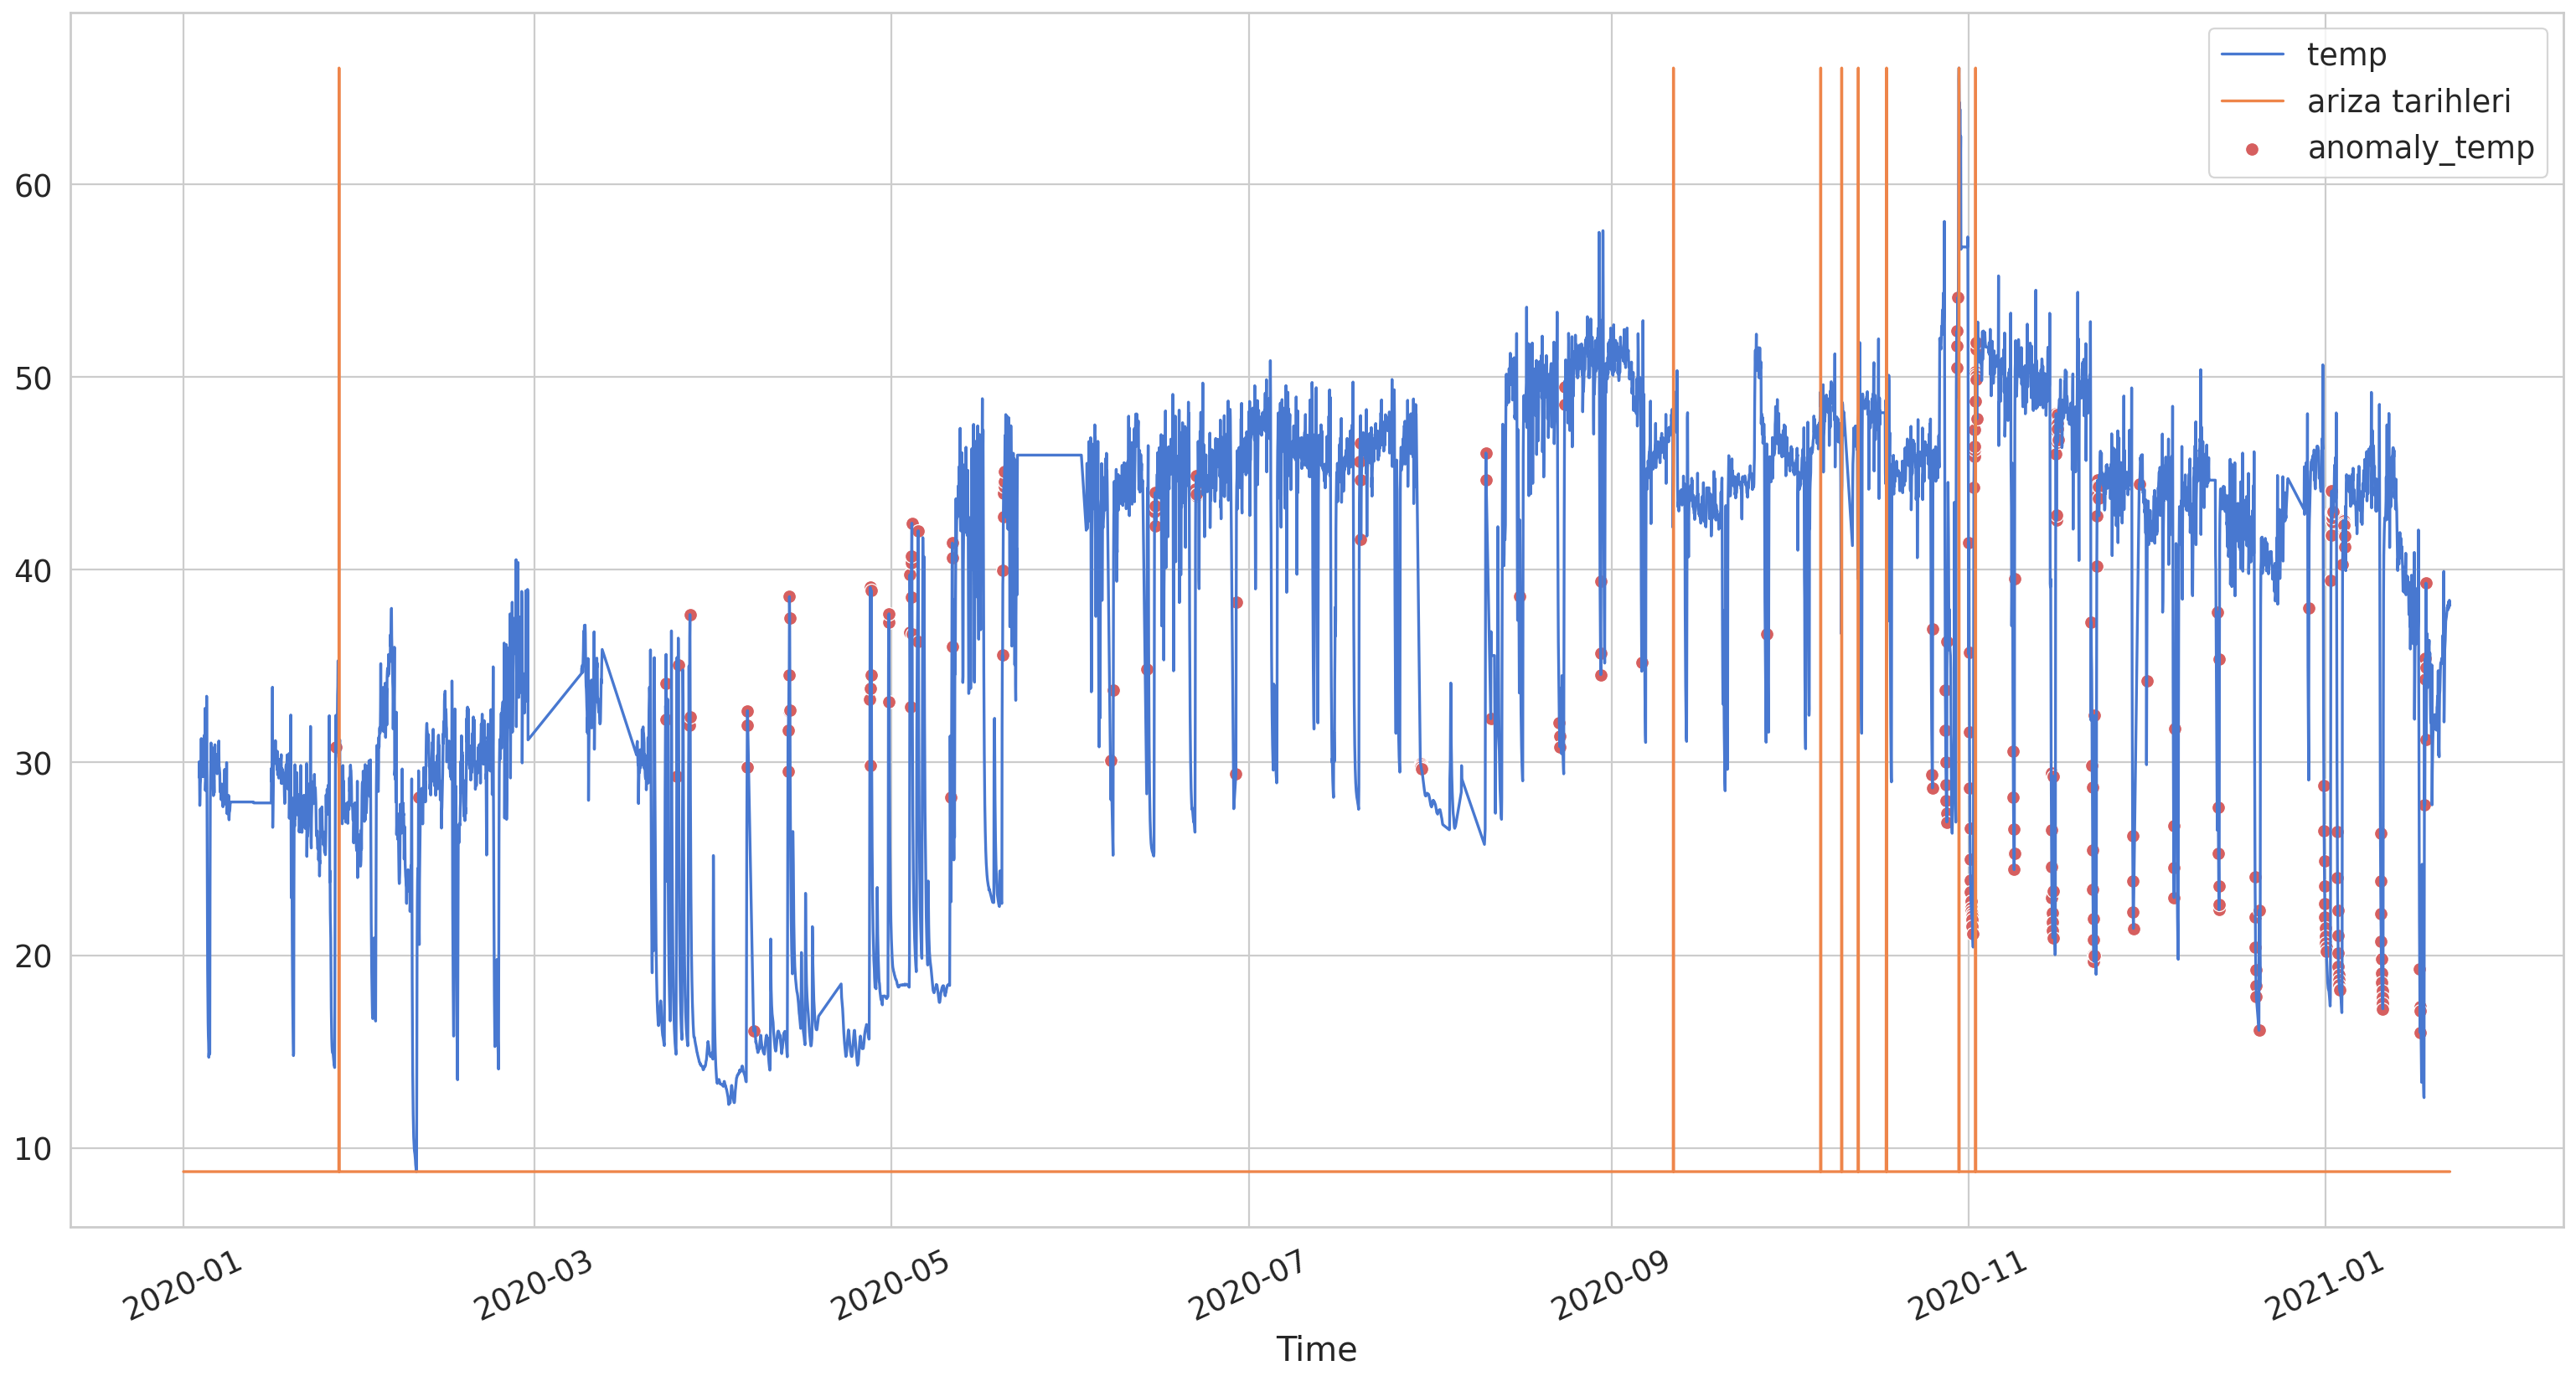

In [31]:
anomaly_plot(test,anomalies=anomalies,col="temp")

# zacc

In [32]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zacc",time_step=24,threshold=1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

zacc**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
8282 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
8283 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
8284 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
8285 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
8286 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6384, 24, 1)
Epoch 1/50
180/180 [==============================] - 4s 9ms/step - loss: 0.1581 - val_loss: 0.0600
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1254 - val_loss: 0.0569
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1198 - val_loss: 0.0552
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1063 - val_loss: 0.0545
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1074 - val_loss: 0.0550
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1030 - val_loss: 0.0570
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0968 - val_loss: 0.0521
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0493
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0899 - val_loss: 0.0502
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0893 - va

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


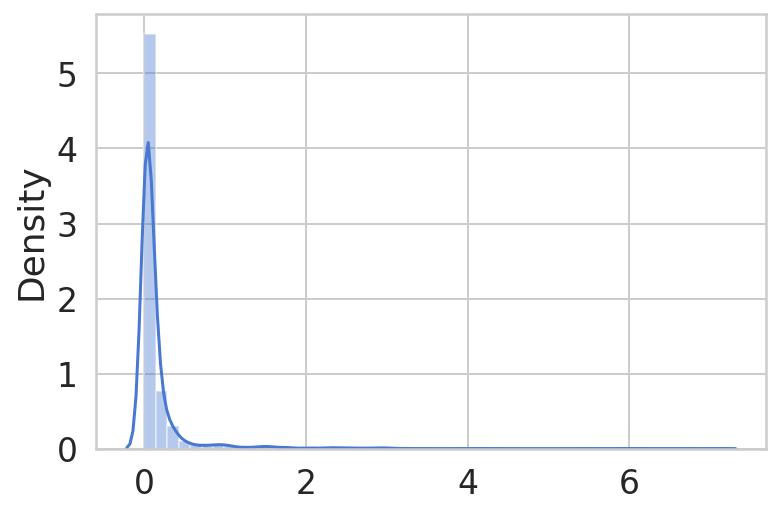

In [33]:
sns.distplot(train_mae_loss, bins=50, kde=True)

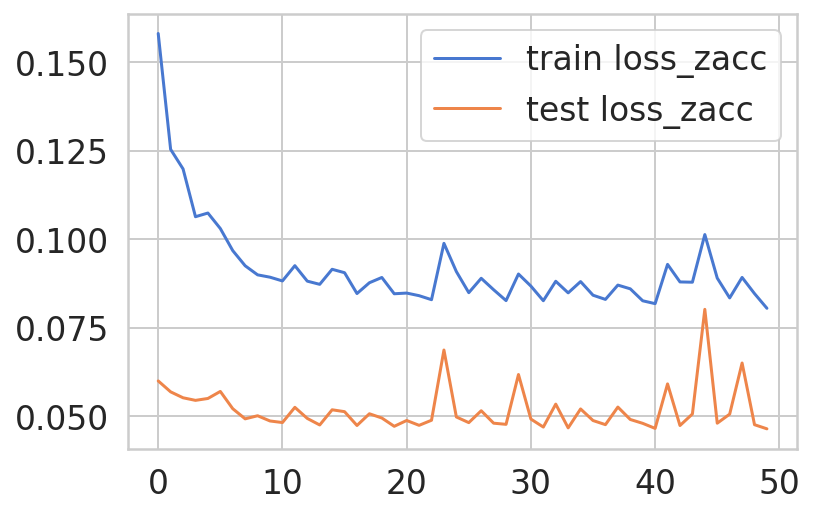

In [34]:
loss_plot()

                         loss  threshold  anomaly      zacc
Time                                                       
2020-09-12 16:00:00  1.038730          1     True  0.988835
2020-09-12 21:00:00  1.188447          1     True  1.873055
2020-09-12 22:00:00  1.393552          1     True  1.559367
2020-09-12 23:00:00  1.117322          1     True  1.695987
2020-09-13 00:00:00  1.130268          1     True  1.796096
2020-09-13 01:00:00  1.130302          1     True  1.173626
2020-09-13 13:00:00  1.623571          1     True -0.276087
2020-09-13 14:00:00  1.233742          1     True -0.428248
2020-09-13 15:00:00  1.513357          1     True -0.441832
2020-09-13 16:00:00  1.493440          1     True -0.441564


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


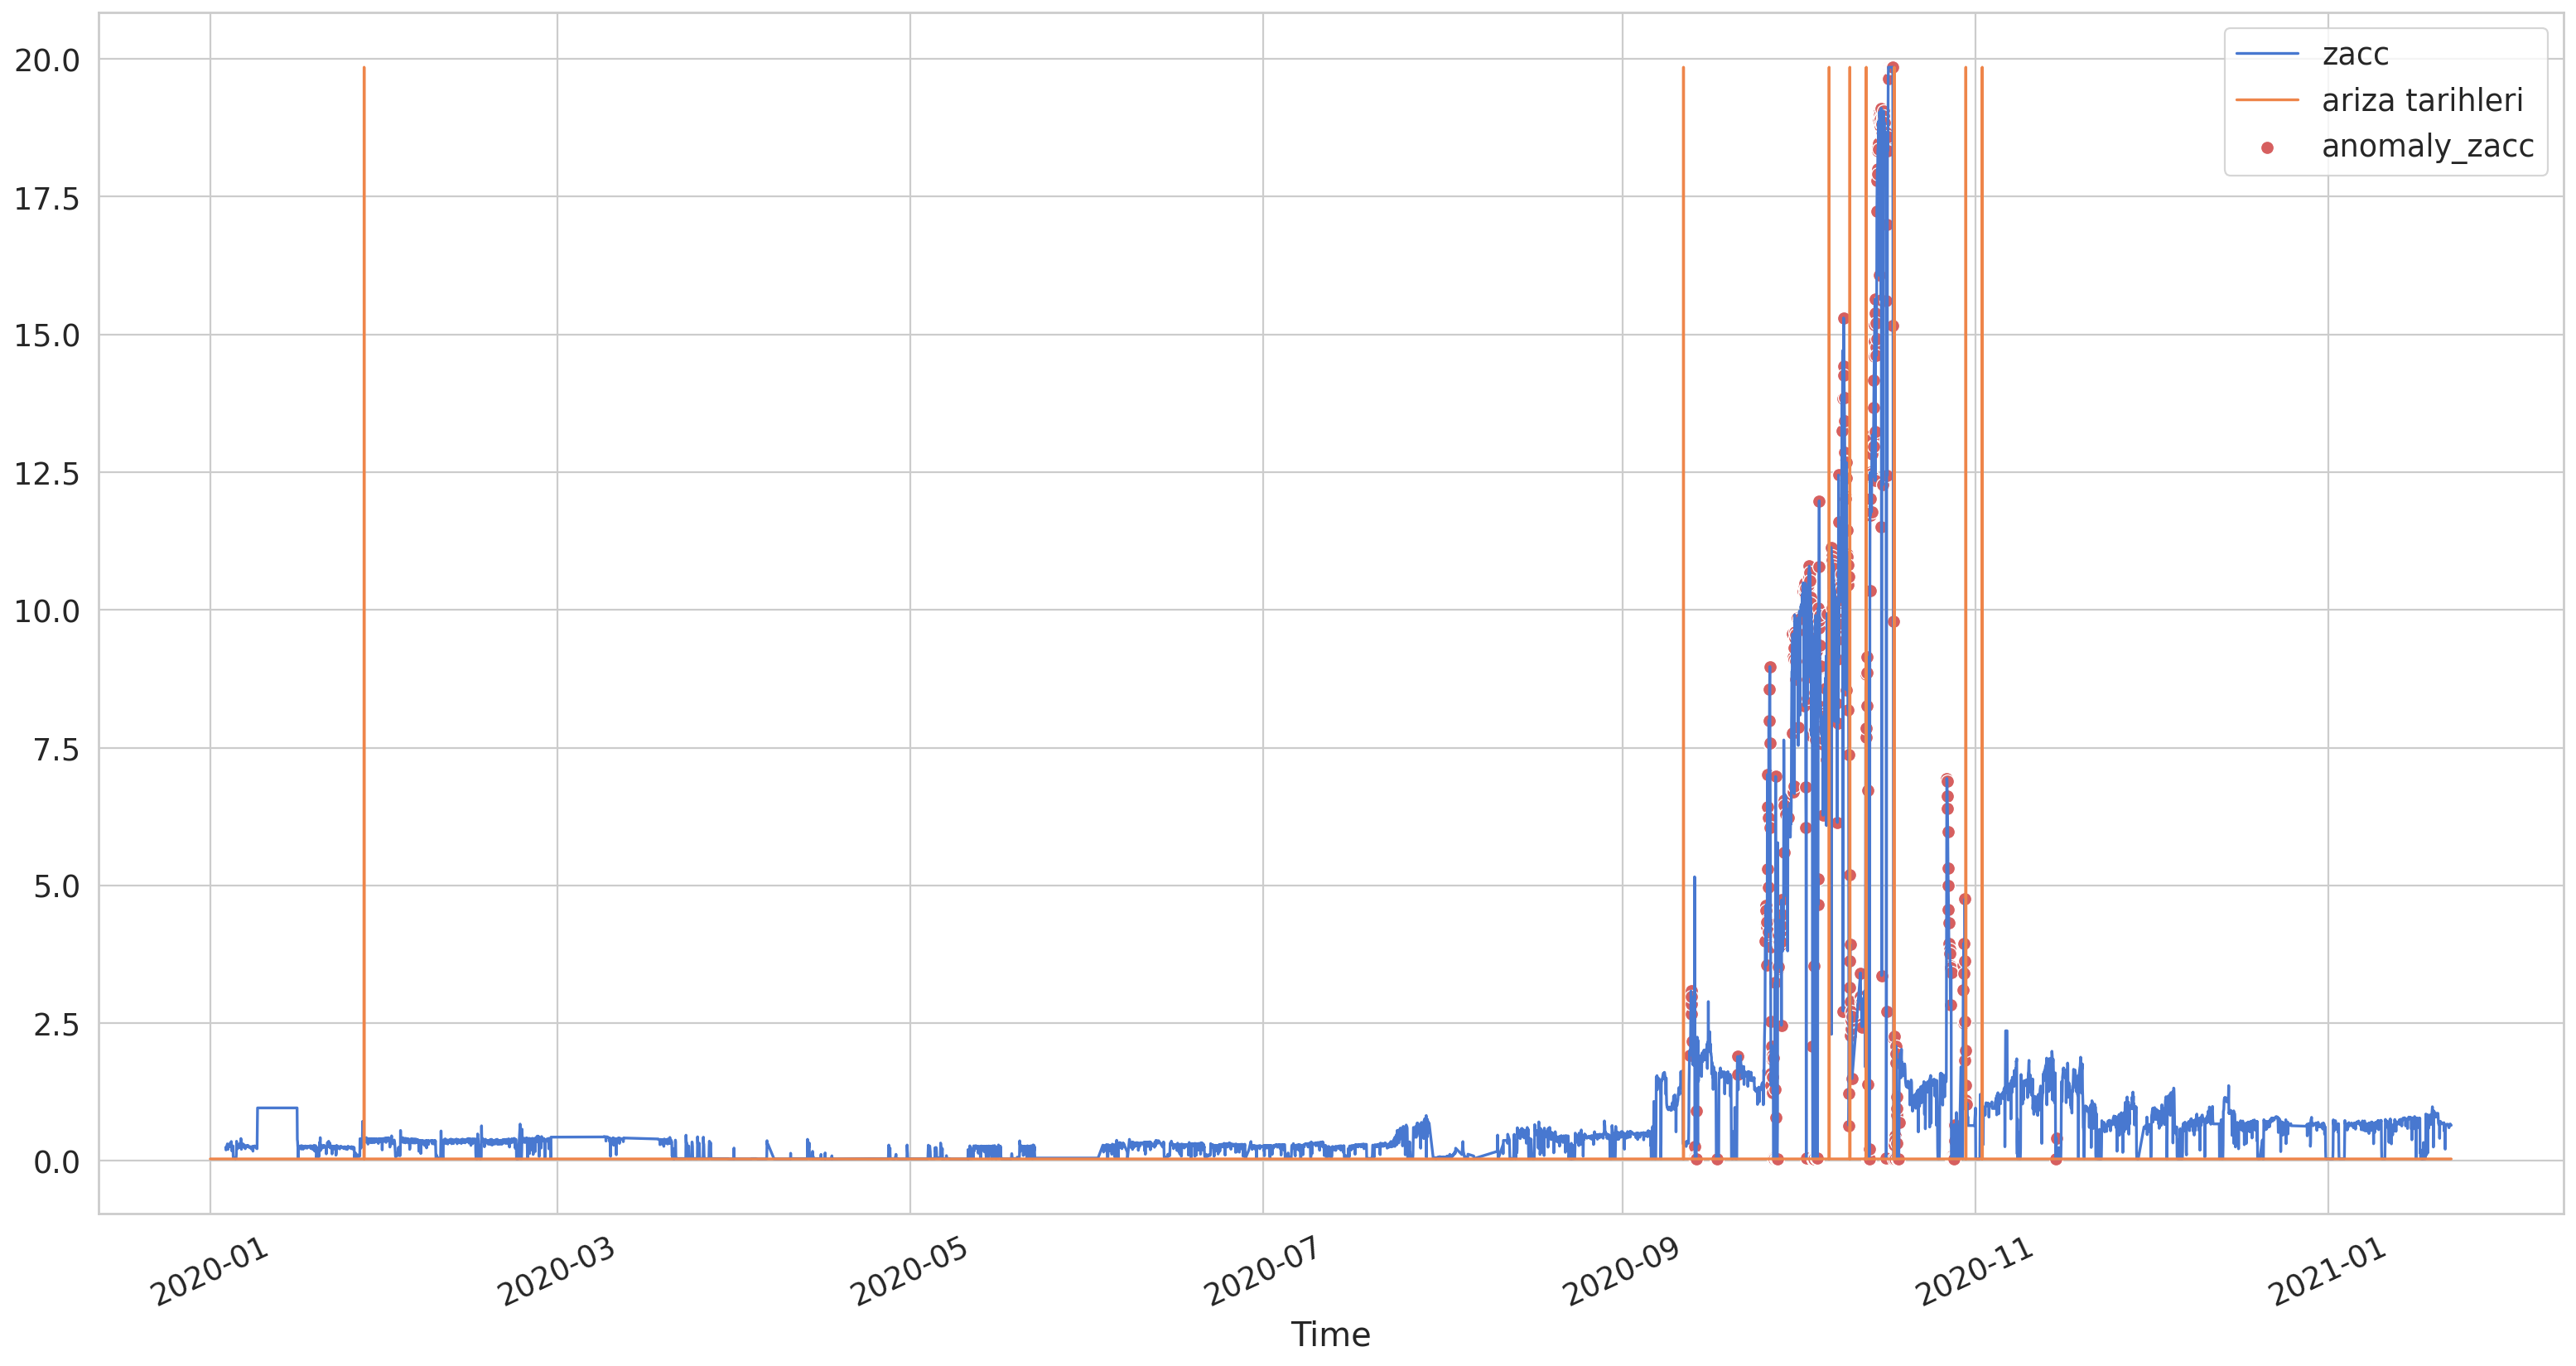

In [35]:
anomaly_plot(test,anomalies=anomalies,col="zacc")

# crest

In [36]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="crest",time_step=24,threshold=2.4)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

crest**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
8282 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
8283 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
8284 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
8285 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
8286 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6384, 24, 1)
Epoch 1/50
180/180 [==============================] - 4s 9ms/step - loss: 0.3370 - val_loss: 0.1448
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2565 - val_loss: 0.1260
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2365 - val_loss: 0.1214
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2304 - val_loss: 0.1200
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2229 - val_loss: 0.1202
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2192 - val_loss: 0.1209
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2132 - val_loss: 0.1168
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2081 - val_loss: 0.1155
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2057 - val_loss: 0.1130
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2043 - va

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


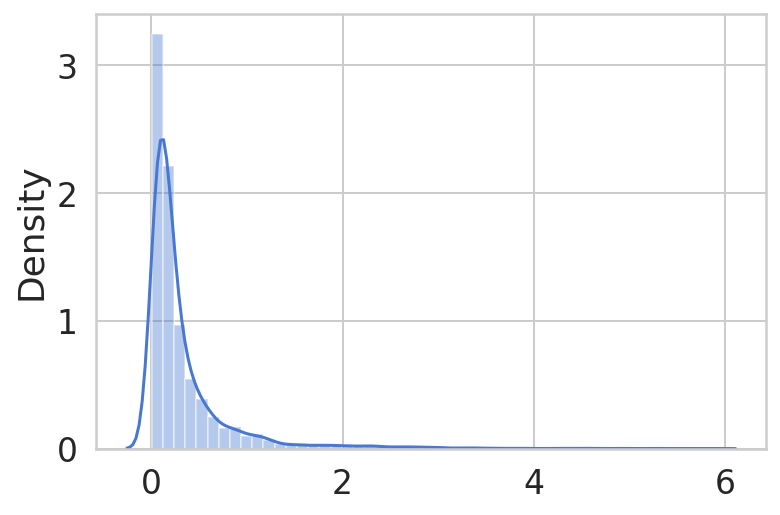

In [37]:
sns.distplot(train_mae_loss, bins=50, kde=True)

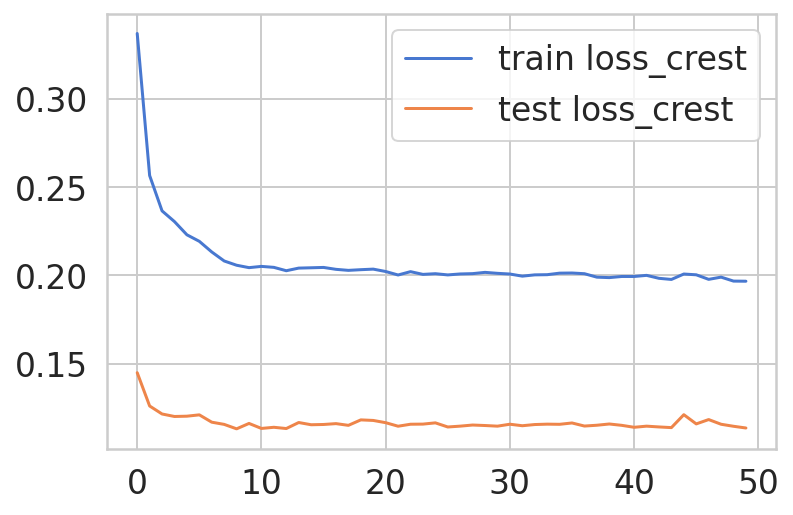

In [38]:
loss_plot()

                         loss  threshold  anomaly     crest
Time                                                       
2020-01-09 04:00:00  2.527756        2.4     True  9.044361
2020-01-09 05:00:00  5.372424        2.4     True  9.044361
2020-01-09 06:00:00  6.266184        2.4     True  9.044361
2020-01-09 07:00:00  6.135174        2.4     True  9.044361
2020-01-09 08:00:00  6.064013        2.4     True  9.044361
2020-01-09 09:00:00  5.955504        2.4     True  9.044361
2020-01-09 10:00:00  5.815657        2.4     True  9.044361
2020-01-09 11:00:00  5.635138        2.4     True  9.044361
2020-01-09 12:00:00  5.450549        2.4     True  9.044361
2020-01-09 13:00:00  5.262404        2.4     True  9.044361


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


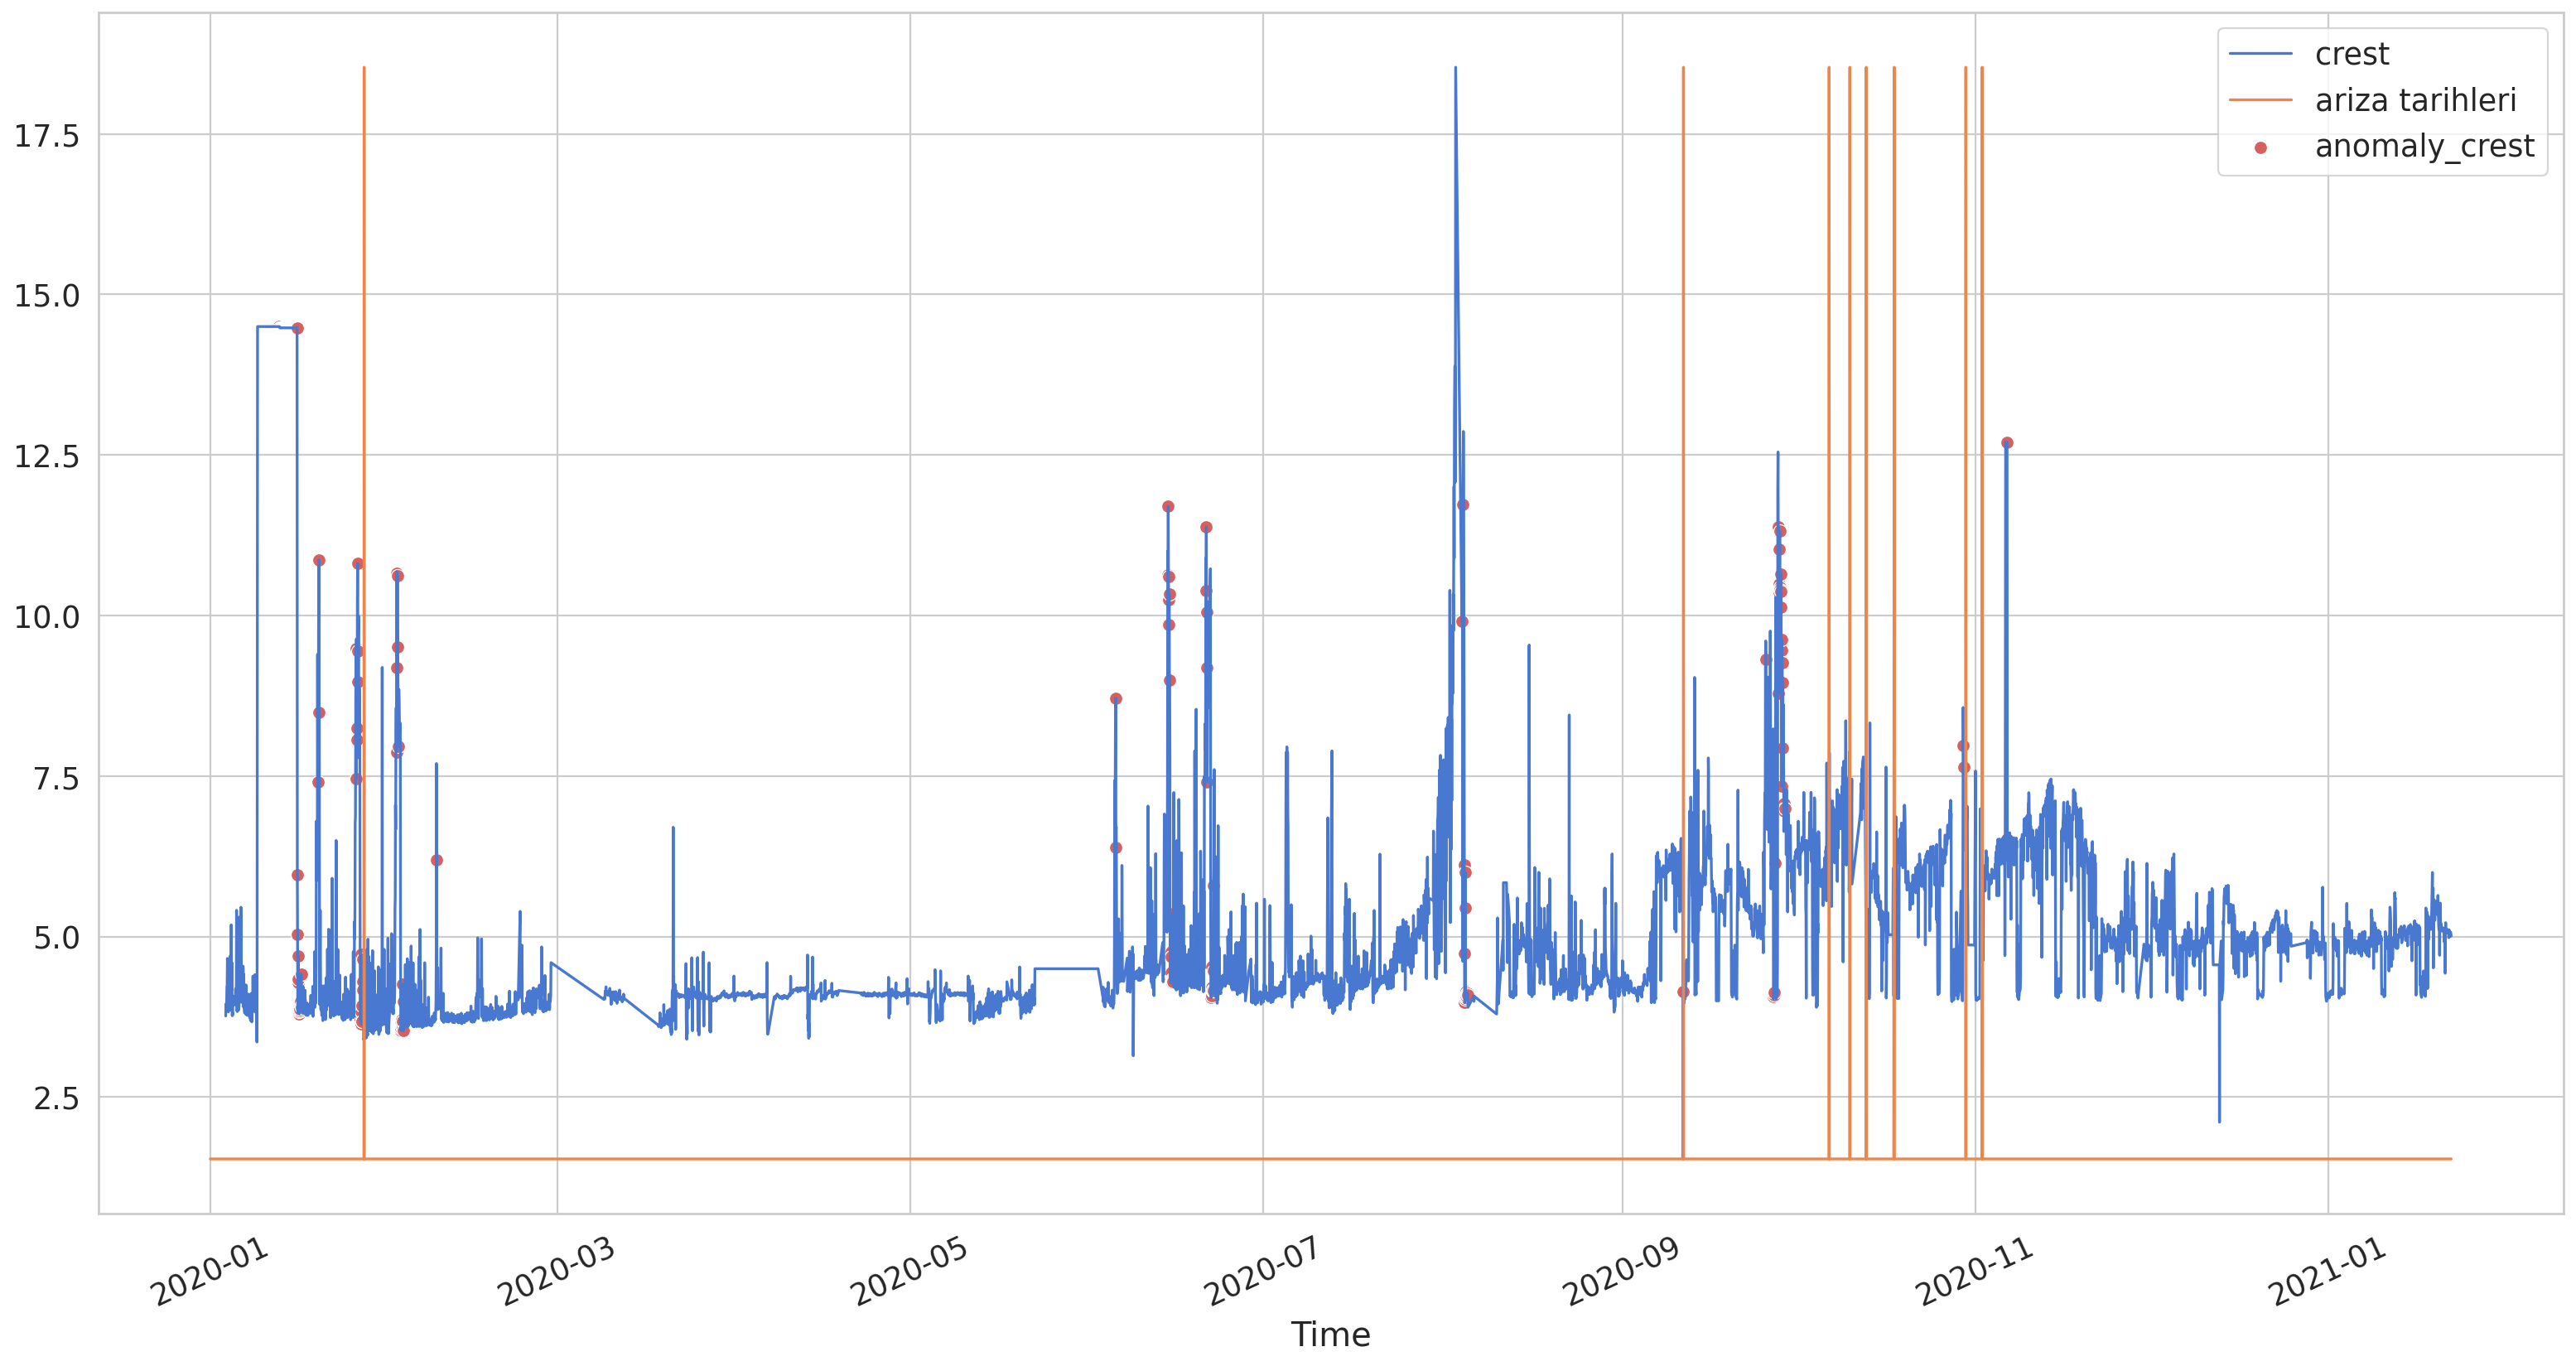

In [39]:
anomaly_plot(test,anomalies=anomalies,col="crest")

# zfreq

In [40]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zfreq",time_step=24,threshold=2)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

zfreq**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
8282 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
8283 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
8284 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
8285 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
8286 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6384, 24, 1)
Epoch 1/50
180/180 [==============================] - 4s 9ms/step - loss: 0.1920 - val_loss: 0.0940
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1416 - val_loss: 0.0768
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1263 - val_loss: 0.0677
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1148 - val_loss: 0.0661
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1115 - val_loss: 0.0644
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1111 - val_loss: 0.0643
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1069 - val_loss: 0.0626
Epoch 8/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1058 - val_loss: 0.0627
Epoch 9/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1039 - val_loss: 0.0604
Epoch 10/50
180/180 [==============================] - 1s 6ms/step - loss: 0.1048 - va

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


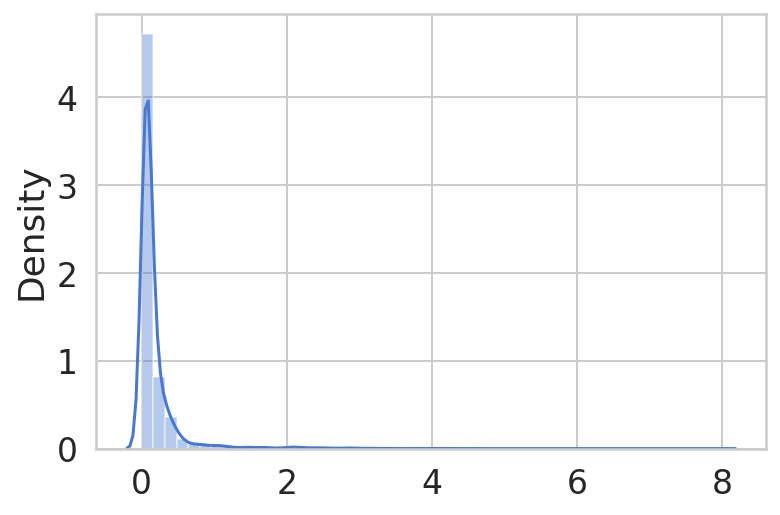

In [41]:
sns.distplot(train_mae_loss, bins=50, kde=True)

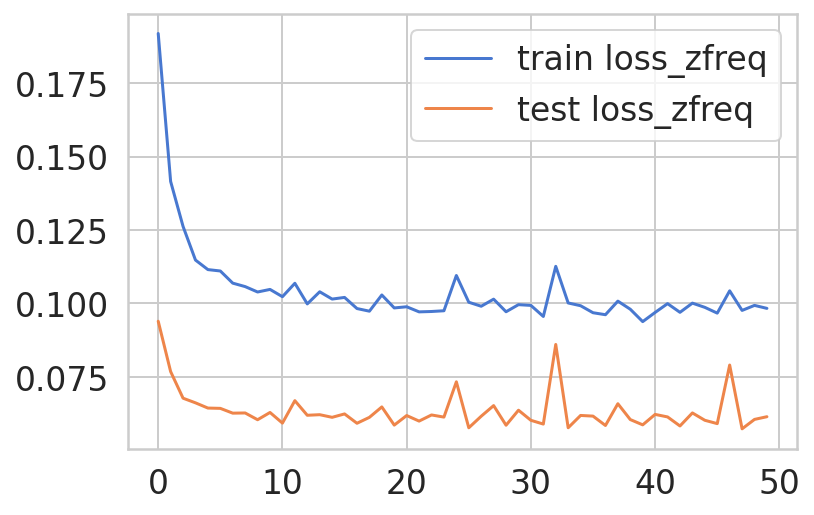

In [42]:
loss_plot()

                         loss  threshold  anomaly     zfreq
Time                                                       
2020-09-26 03:00:00  2.646541          2     True  3.842513
2020-09-26 04:00:00  2.136092          2     True  2.604588
2020-09-26 09:00:00  2.884883          2     True  3.778271
2020-09-26 11:00:00  2.072148          2     True  5.205746
2020-09-26 12:00:00  2.469180          2     True  5.732781
2020-09-26 13:00:00  2.689754          2     True  4.967736
2020-09-26 14:00:00  2.050434          2     True  2.827109
2020-09-26 18:00:00  2.386055          2     True  0.713465
2020-09-26 19:00:00  2.131589          2     True  0.749677
2020-09-26 20:00:00  2.104578          2     True  0.578509


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


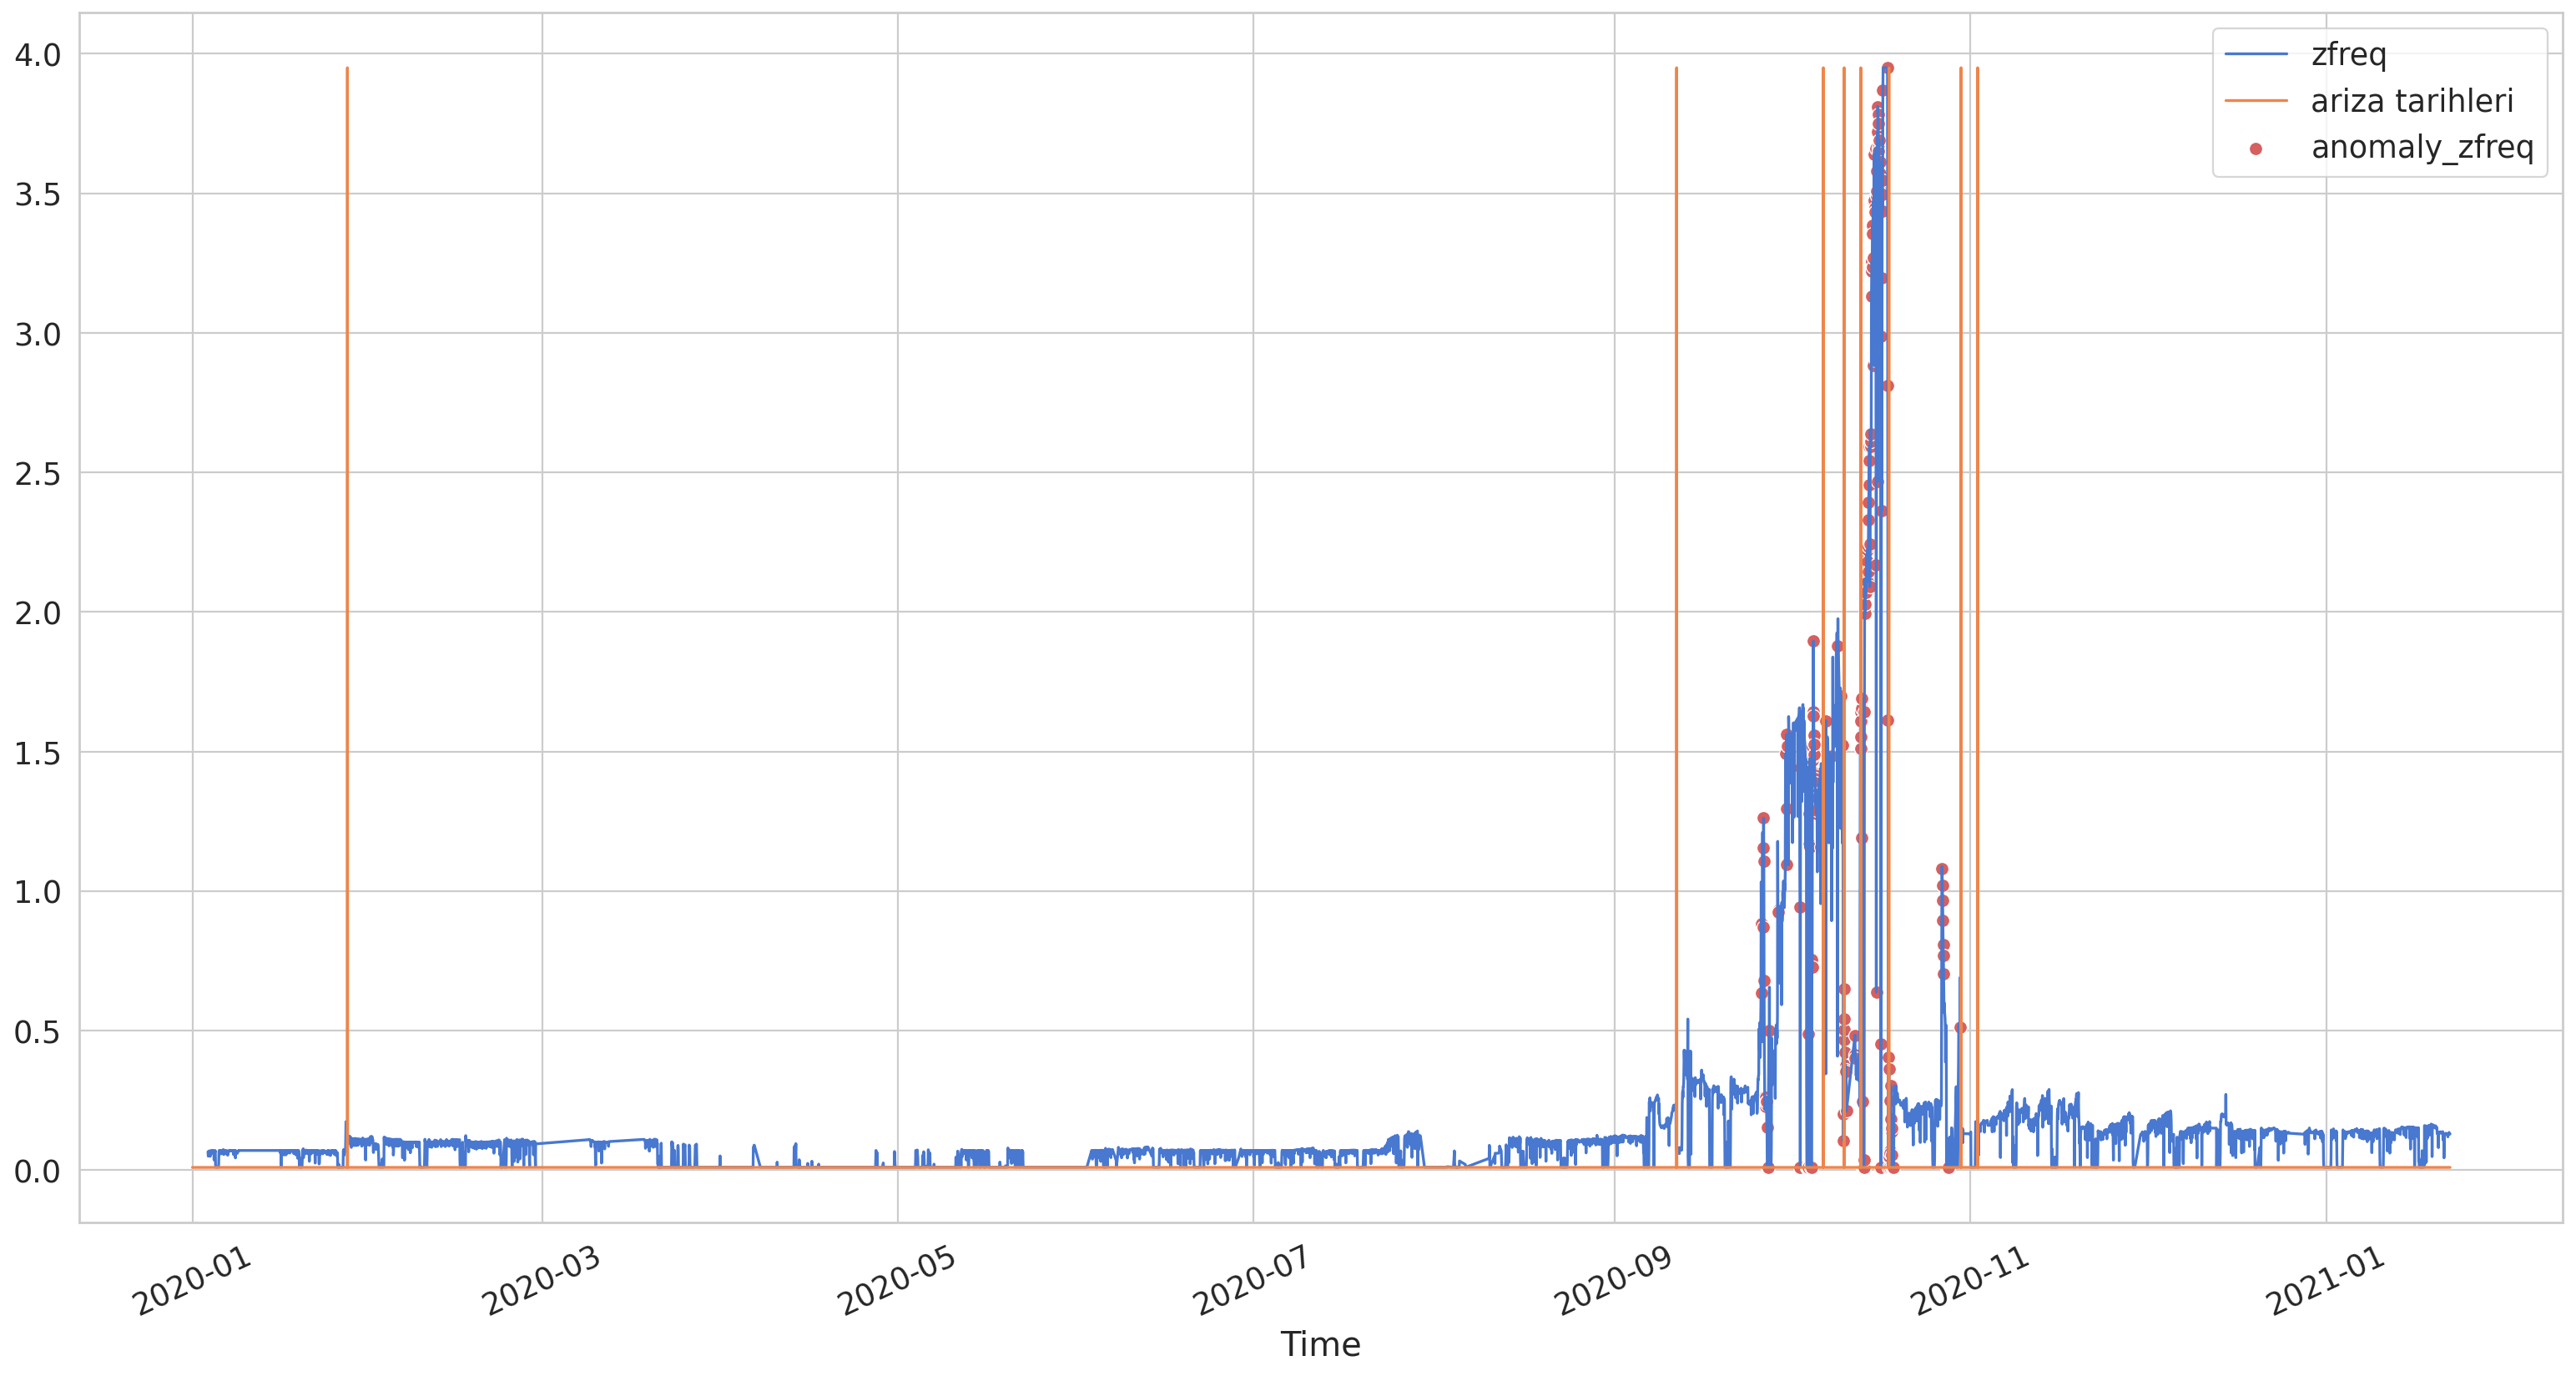

In [43]:
anomaly_plot(test,anomalies=anomalies,col="zfreq")

In [44]:
ariza_tarihleri_plot= []
for i in [str(a) for a in data1["Time"]]:
          if i not in [str(b) for b in ariza_tarihleri]:
            ariza_tarihleri_plot.append(1)
          else:
            ariza_tarihleri_plot.append(5)
ariza=pd.DataFrame(ariza_tarihleri_plot)
ariza.index=data1["Time"]
ariza.columns=["ariza tarihleri"]

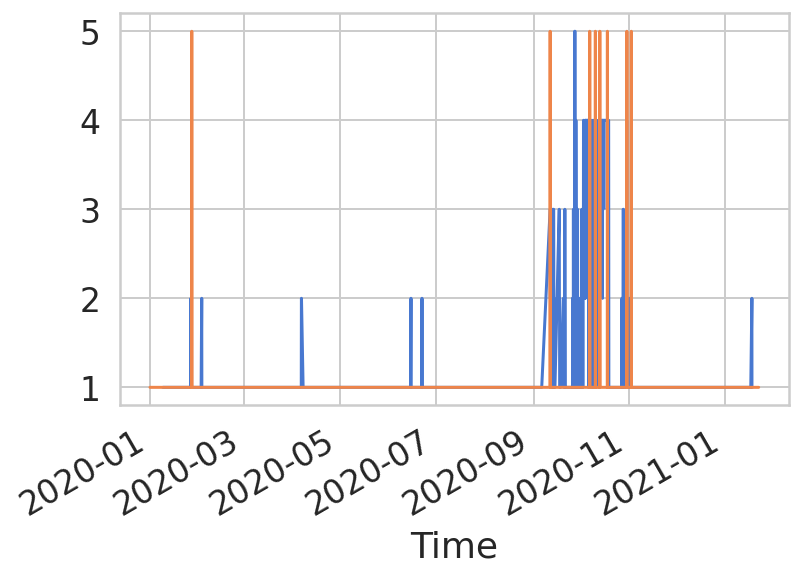

In [45]:
total_anomalies.groupby("Time")["anomaly_count"].sum().plot()
ariza["ariza tarihleri"].plot()

In [46]:
total_anomalies["Time"].value_counts()

2020-09-27 04:00:00    5
2020-09-27 10:00:00    5
2020-09-27 06:00:00    5
2020-09-27 05:00:00    5
2020-10-30 06:00:00    4
                      ..
2020-02-03 06:00:00    1
2020-01-12 16:00:00    1
2020-10-08 23:00:00    1
2020-04-13 07:00:00    1
2020-09-26 00:00:00    1
Name: Time, Length: 1162, dtype: int64

In [47]:
total_anomalies.to_csv("total_anomaly.csv")